In [5]:
import torch
from argparse import Namespace
from regressionFlow.models.networks_regression_SDD import HyperRegression

import matplotlib.pyplot as plt
%matplotlib inline

flow_args = Namespace(model_type='PointNet', logprob_type='Laplace', input_dim=1, dims='3-4-2',
                                   latent_dims='256', hyper_dims='128-32', num_blocks=1, latent_num_blocks=1,
                                   layer_type='concatsquash', time_length=0.5, train_T=True, nonlinearity='tanh',
                                   use_adjoint=True, solver='dopri5', atol=1e-05, rtol=1e-05, batch_norm=True,
                                   sync_bn=False, bn_lag=0, root_dir=None, use_latent_flow=False,
                                   use_deterministic_encoder=False,
                                   zdim=1, optimizer='adam', batch_size=1000, lr=0.001, beta1=0.9,
                                   beta2=0.999, momentum=0.9, weight_decay=1e-05, epochs=1000, seed=694754,
                                   recon_weight=1.0, prior_weight=1.0, entropy_weight=1.0, scheduler='linear',
                                   exp_decay=1.0, exp_decay_freq=1, image_size='28x28', data_dir='data/SDD/',
                                   dataset_type='shapenet15k', cates=['airplane'],
                                   mn40_data_dir='data/ModelNet40.PC15k',
                                   mn10_data_dir='data/ModelNet10.PC15k', dataset_scale=1.0, random_rotate=False,
                                   normalize_per_shape=False, normalize_std_per_axis=False, tr_max_sample_points=2048,
                                   te_max_sample_points=2048, num_workers=4, use_all_data=False,
                                   log_name='experiment_regression_flow_toy', viz_freq=1, val_freq=10, log_freq=1,
                                   save_freq=5, no_validation=False, save_val_results=False, eval_classification=False,
                                   no_eval_sampling=False, max_validate_shapes=None, resume_checkpoint=None,
                                   resume_optimizer=False, resume_non_strict=False, resume_dataset_mean=None,
                                   resume_dataset_std=None, world_size=1, dist_url='tcp://127.0.0.1:9991',
                                   dist_backend='nccl', distributed=False, rank=0, gpu=0, evaluate_recon=False,
                                   num_sample_shapes=10, num_sample_points=2048, use_sphere_dist=False,
                                   use_div_approx_train=False, use_div_approx_test=False)


def _get_opt_(params):
    if flow_args.optimizer == 'adam':
        optimizer = torch.optim.Adam(params, lr=flow_args.lr, betas=(flow_args.beta1, flow_args.beta2),
                               weight_decay=flow_args.weight_decay)
    elif flow_args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(params, lr=flow_args.lr, momentum=flow_args.momentum)
    else:
        assert 0, "args.optimizer should be either 'adam' or 'sgd'"
    return optimizer

def plotTheta(theta,loss):
    X = theta.cpu().detach().numpy().reshape(65,5)
    
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    plt.plot(X_r[:,0],X_r[:,1],".")
    plt.show()

tensor(3.9633, device='cuda:0', grad_fn=<MulBackward0>)


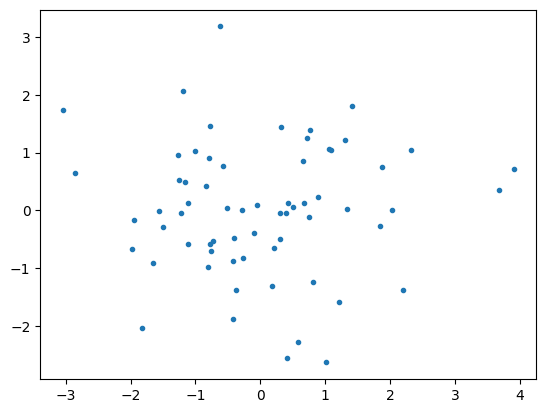

tensor(3.2403, device='cuda:0', grad_fn=<MulBackward0>)


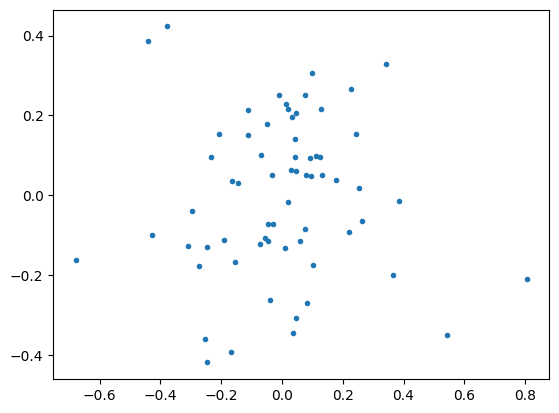

tensor(2.9318, device='cuda:0', grad_fn=<MulBackward0>)


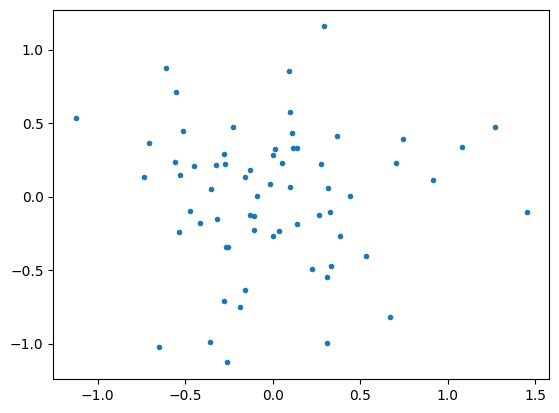

tensor(3.0326, device='cuda:0', grad_fn=<MulBackward0>)


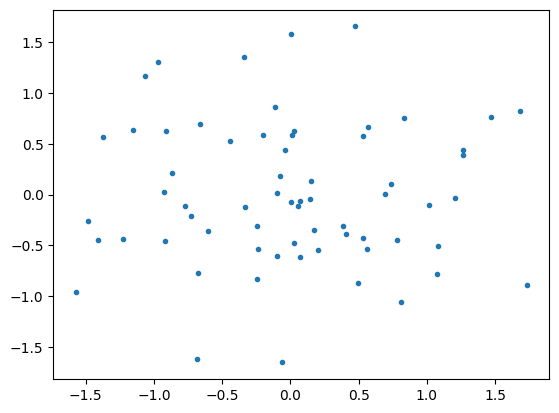

tensor(3.1112, device='cuda:0', grad_fn=<MulBackward0>)


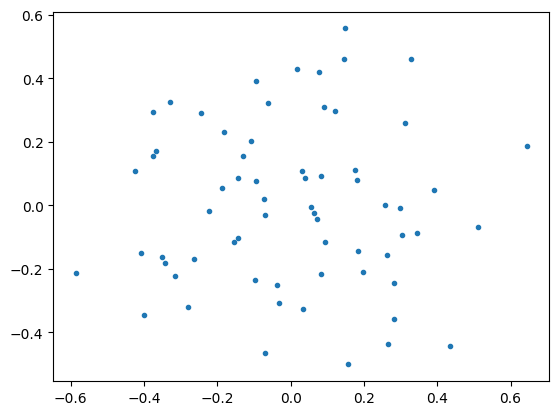

tensor(3.0475, device='cuda:0', grad_fn=<MulBackward0>)


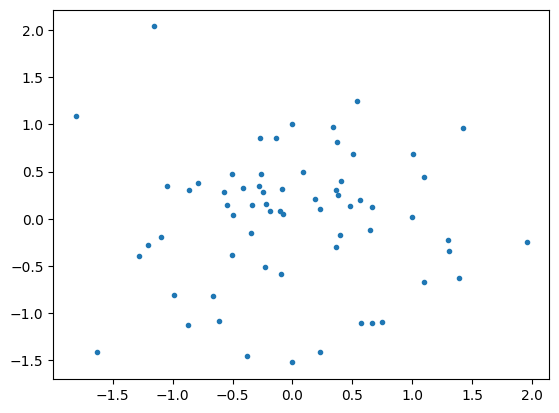

tensor(3.3317, device='cuda:0', grad_fn=<MulBackward0>)


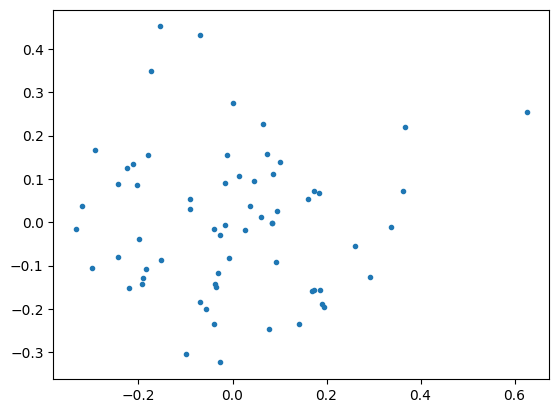

tensor(3.8448, device='cuda:0', grad_fn=<MulBackward0>)


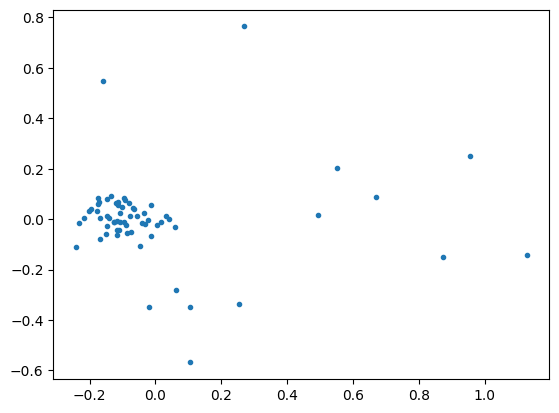

tensor(3.3299, device='cuda:0', grad_fn=<MulBackward0>)


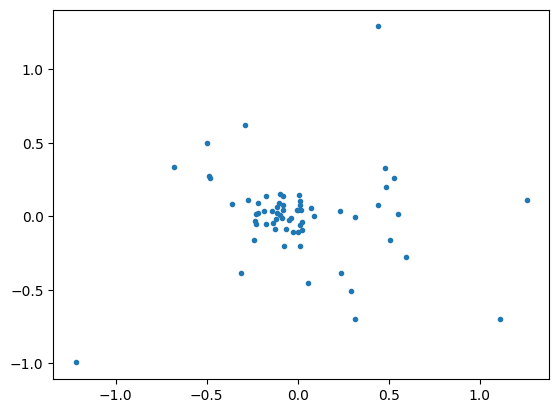

tensor(3.1934, device='cuda:0', grad_fn=<MulBackward0>)


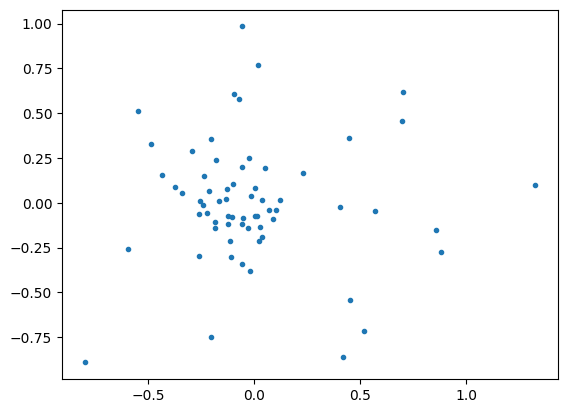

tensor(2.9483, device='cuda:0', grad_fn=<MulBackward0>)


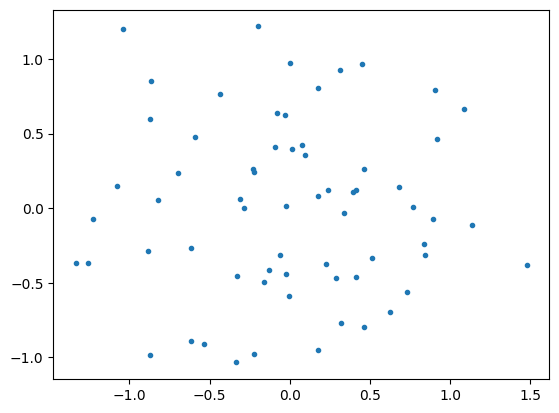

tensor(3.0273, device='cuda:0', grad_fn=<MulBackward0>)


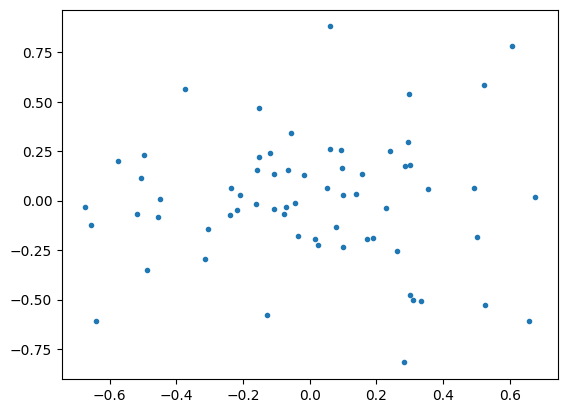

tensor(4.9842, device='cuda:0', grad_fn=<MulBackward0>)


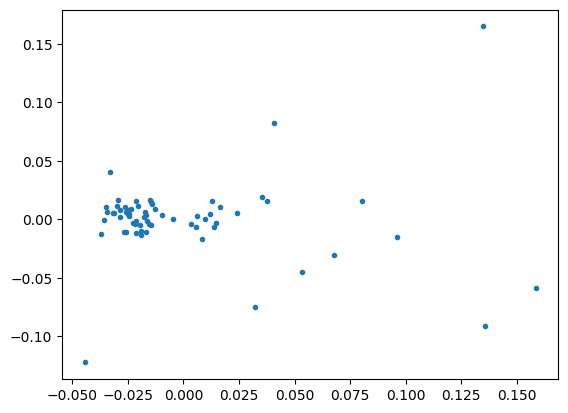

tensor(4.1517, device='cuda:0', grad_fn=<MulBackward0>)


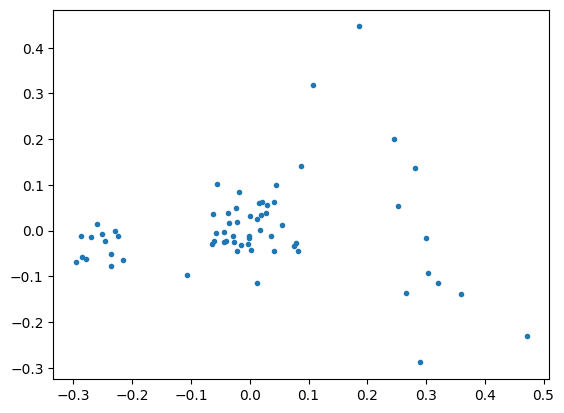

tensor(6.0358, device='cuda:0', grad_fn=<MulBackward0>)


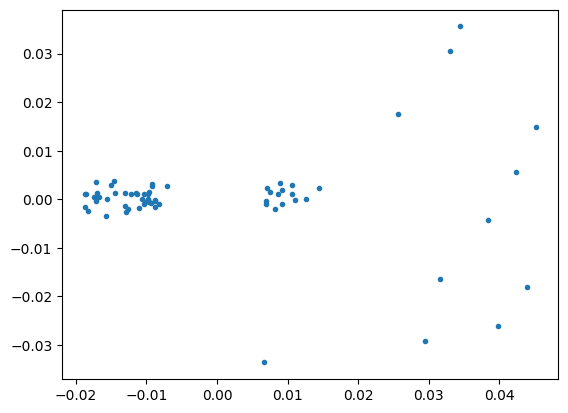

tensor(5.6828, device='cuda:0', grad_fn=<MulBackward0>)


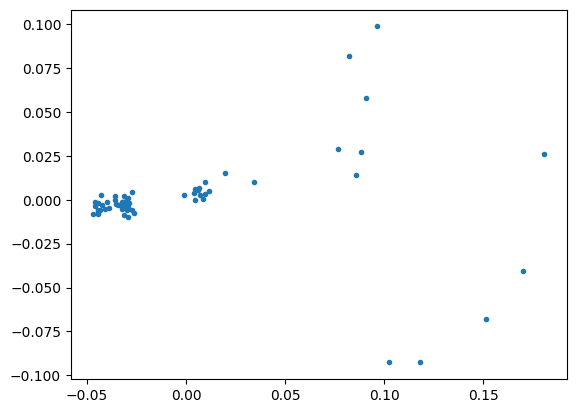

tensor(4.7792, device='cuda:0', grad_fn=<MulBackward0>)


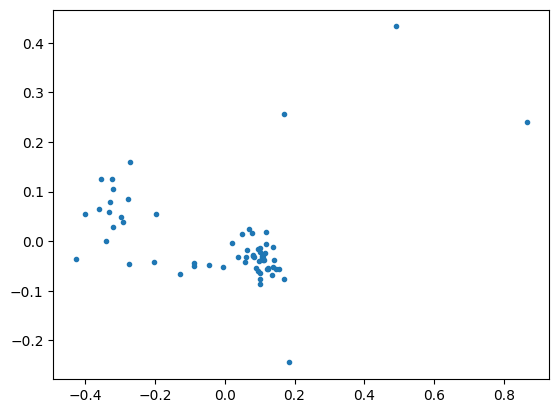

tensor(2.9630, device='cuda:0', grad_fn=<MulBackward0>)


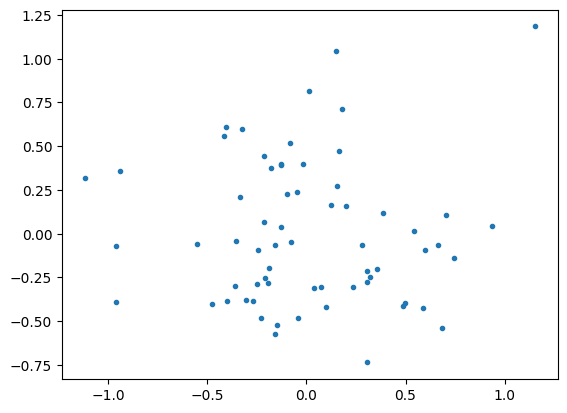

tensor(3.6259, device='cuda:0', grad_fn=<MulBackward0>)


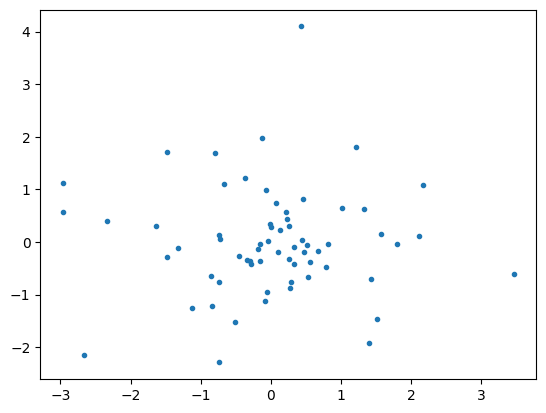

tensor(4.0675, device='cuda:0', grad_fn=<MulBackward0>)


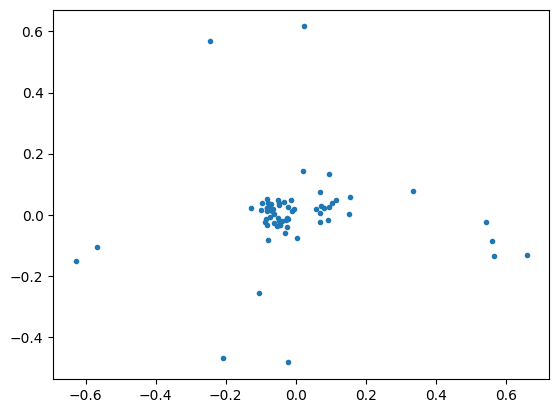

tensor(4.1392, device='cuda:0', grad_fn=<MulBackward0>)


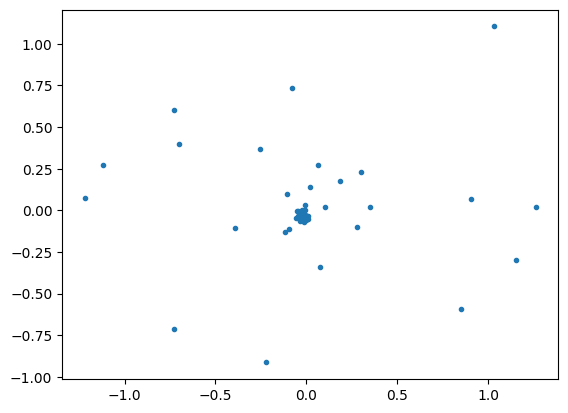

In [6]:
flow = HyperRegression(flow_args)
opt = _get_opt_(list(flow.hyper.parameters()) + list(flow.point_cnf.parameters()))

import torch
from regressionFlow.utils import truncated_normal, standard_normal_logprob, standard_laplace_logprob

# flow hypernetwork with kld loss
def experiment_flow1(flow, opt,n):
    support = torch.randn(5,65)
    for i in range(n):
        x = support
        y = flow.sample_gaussian((*x.shape, flow.input_dim), None, flow.gpu)
        opt.zero_grad()
        batch_size = x.size(0)
        x = flow.hyper(x)
        target_networks_weights = flow.point_cnf(y, x, reverse=True).view(*y.size())

        # Loss
        _, delta_log_py = flow.point_cnf(target_networks_weights, x, torch.zeros(batch_size, y.size(1), 1).to(y))
        log_py = standard_normal_logprob(y).view(batch_size, -1).sum(1, keepdim=True)
        delta_log_py = delta_log_py.view(batch_size, y.size(1), 1).sum(1)
        log_px = log_py - delta_log_py

        # policzyc gestosci flowa log p_0(F^{-1}_\theta(w_i) + J
        loss = log_px.mean()

        # policzyc gestosci priora log N(w_i | (0,I))
        size_multivariate = target_networks_weights.flatten().size()[0]
        multivariate_normal_distrib = torch.distributions.MultivariateNormal(
                torch.zeros_like(target_networks_weights.flatten()).to(loss), torch.eye(size_multivariate).to(loss))
        loss_density = multivariate_normal_distrib.log_prob(target_networks_weights.flatten())
        loss = 0.01 * (loss - loss_density)

        # loss = torch.norm(loss)

        if i % 100 == 0 or i == n-1:
            print(loss)
            plotTheta(target_networks_weights,loss)
        loss.backward()
        opt.step()

experiment_flow1(flow,opt,2000)

tensor(18.2087, device='cuda:0', grad_fn=<CopyBackwards>)


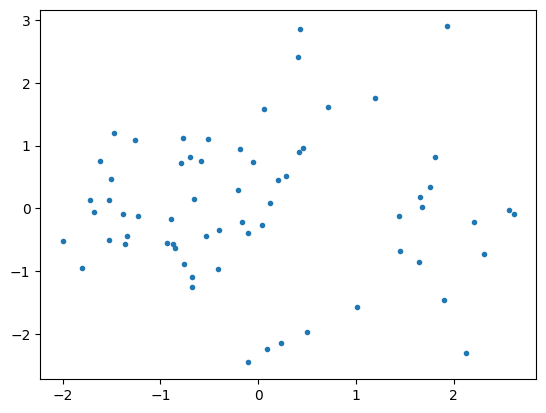

tensor(0.4193, device='cuda:0', grad_fn=<CopyBackwards>)


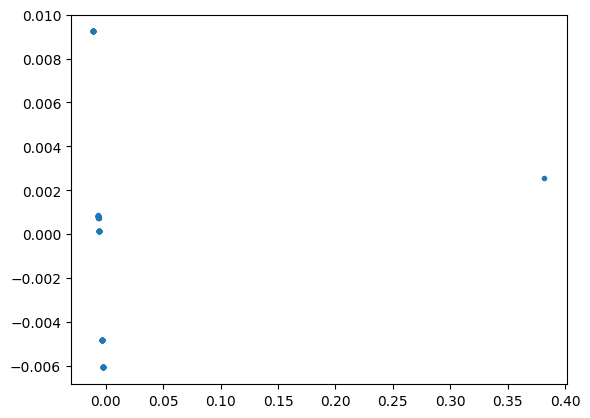

tensor(0.0703, device='cuda:0', grad_fn=<CopyBackwards>)


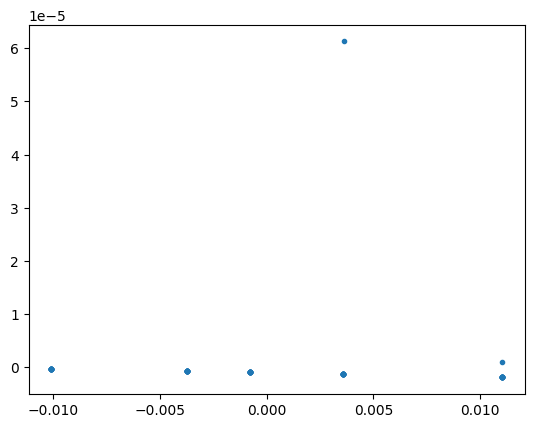

tensor(0.0348, device='cuda:0', grad_fn=<CopyBackwards>)


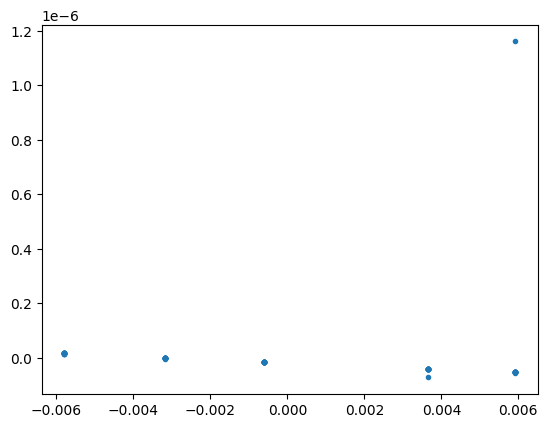

tensor(0.0222, device='cuda:0', grad_fn=<CopyBackwards>)


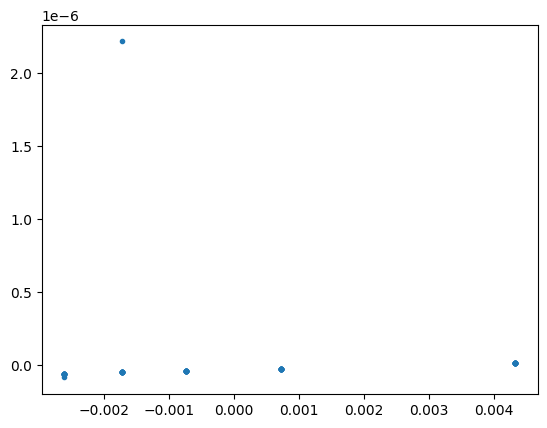

tensor(0.0184, device='cuda:0', grad_fn=<CopyBackwards>)


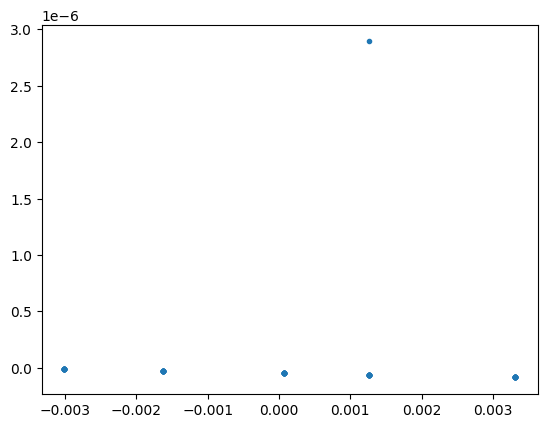

tensor(0.0168, device='cuda:0', grad_fn=<CopyBackwards>)


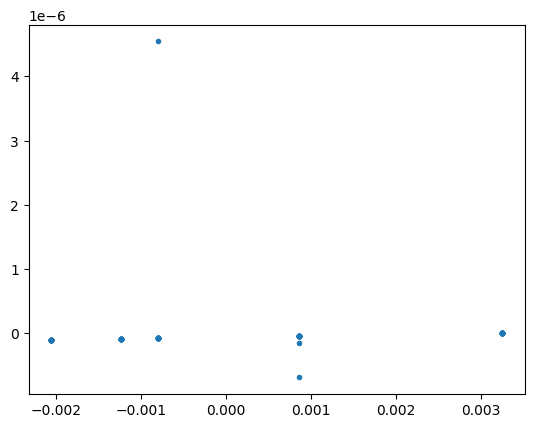

In [ ]:
flow = HyperRegression(flow_args)
opt = _get_opt_(list(flow.hyper.parameters()) + list(flow.point_cnf.parameters()))

import torch
from regressionFlow.utils import truncated_normal, standard_normal_logprob, standard_laplace_logprob

# flow hypernetwork with norm loss
def experiment_flow2(flow, opt,n):
    support = torch.randn(5,65)
    for i in range(n):
        x = support
        y = flow.sample_gaussian((*x.shape, flow.input_dim), None, flow.gpu)
        opt.zero_grad()
        x = flow.hyper(x)
        target_networks_weights = flow.point_cnf(y, x, reverse=True).view(*y.size())

        loss = torch.norm(torch.flatten(target_networks_weights))

        if i % 100 == 0 or i == n-1:
            print(loss)
            plotTheta(target_networks_weights,loss)
        loss.backward()
        opt.step()

experiment_flow2(flow,opt,2000)

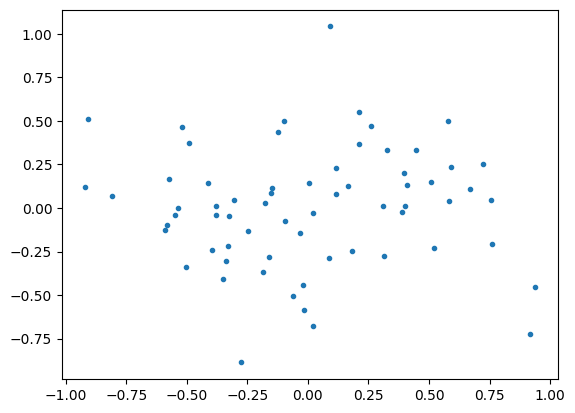

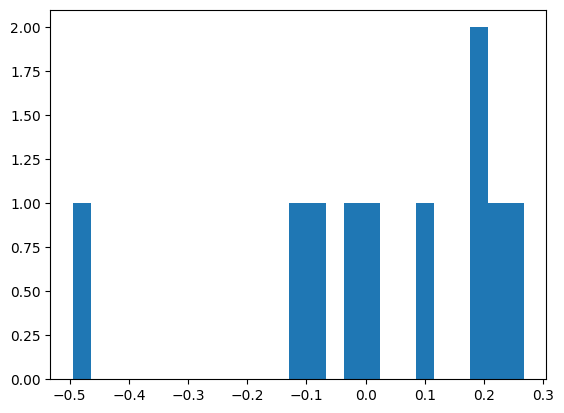

iter no. 0 mu=-0.10810083150863647, std=1.0650880336761475, loss=3.8897464275360107
iter no. 1 mu=-0.13177873194217682, std=1.0722451210021973, loss=3.9173989295959473
iter no. 2 mu=-0.052337054163217545, std=1.0349186658859253, loss=3.7894279956817627
iter no. 3 mu=0.03652336075901985, std=1.0766096115112305, loss=3.9052906036376953
iter no. 4 mu=0.1840982884168625, std=1.01542067527771, loss=3.785226821899414
iter no. 5 mu=0.33669763803482056, std=0.9979374408721924, loss=3.8680782318115234
iter no. 6 mu=0.43164175748825073, std=0.9985069036483765, loss=3.990849733352661
iter no. 7 mu=0.5711460113525391, std=0.9704039692878723, loss=4.1461920738220215
iter no. 8 mu=0.6158304810523987, std=0.9124794006347656, loss=4.099551200866699
iter no. 9 mu=0.6347094178199768, std=0.8959095478057861, loss=4.101222038269043
iter no. 10 mu=0.6501089930534363, std=0.8550920486450195, loss=4.052155494689941
iter no. 11 mu=0.6766082644462585, std=0.76791912317276, loss=3.9490201473236084
iter no. 12 m

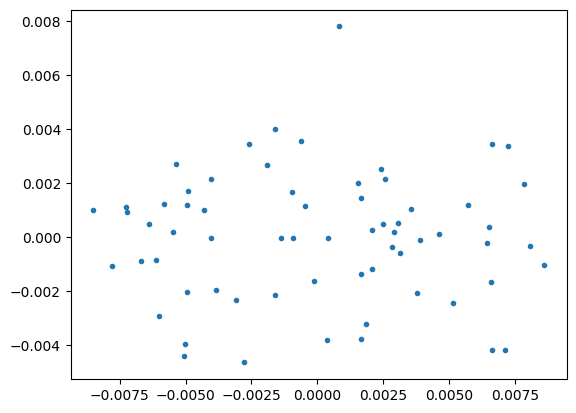

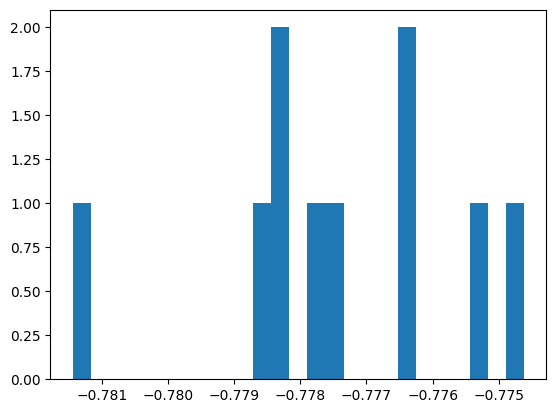

iter no. 50 mu=-0.7752866744995117, std=0.007706903386861086, loss=6.252284526824951
iter no. 51 mu=-0.7825992703437805, std=0.007545557338744402, loss=6.27960205078125
iter no. 52 mu=-0.7886956930160522, std=0.0073377215303480625, loss=6.311767578125
iter no. 53 mu=-0.7955265641212463, std=0.007180127780884504, loss=6.3540472984313965
iter no. 54 mu=-0.8018586039543152, std=0.0068842568434774876, loss=6.398139953613281
iter no. 55 mu=-0.8085283637046814, std=0.006900619715452194, loss=6.405759334564209
iter no. 56 mu=-0.8151234984397888, std=0.006946044508367777, loss=6.422878265380859
iter no. 57 mu=-0.8218725323677063, std=0.006844025105237961, loss=6.447337627410889
iter no. 58 mu=-0.8283891081809998, std=0.006662160158157349, loss=6.489508152008057
iter no. 59 mu=-0.8356010913848877, std=0.006649233400821686, loss=6.507527828216553
iter no. 60 mu=-0.8428106904029846, std=0.006582104600965977, loss=6.536998748779297
iter no. 61 mu=-0.8500178456306458, std=0.0065155415795743465, los

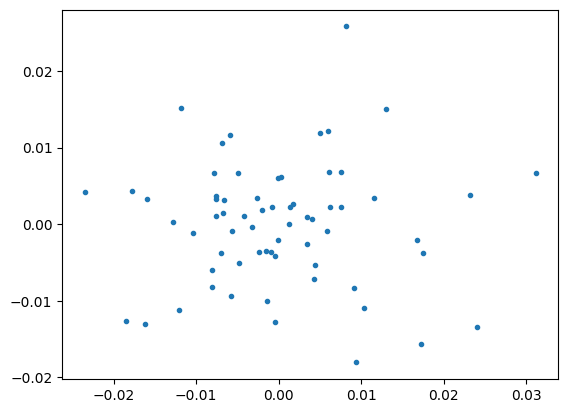

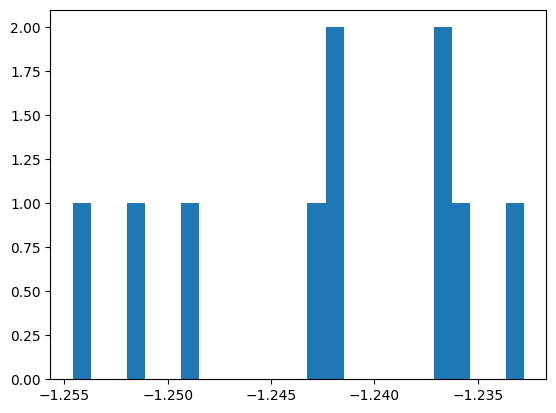

iter no. 100 mu=-1.237729549407959, std=0.024015935137867928, loss=7.067364692687988
iter no. 101 mu=-1.2574515342712402, std=0.026712555438280106, loss=7.095353126525879
iter no. 102 mu=-1.2799808979034424, std=0.029283607378602028, loss=7.11736536026001
iter no. 103 mu=-1.3037089109420776, std=0.0324070043861866, loss=7.165509223937988
iter no. 104 mu=-1.3291062116622925, std=0.037754129618406296, loss=7.189329624176025
iter no. 105 mu=-1.3600496053695679, std=0.043994512408971786, loss=7.22948694229126
iter no. 106 mu=-1.3893731832504272, std=0.04929047450423241, loss=7.2859978675842285
iter no. 107 mu=-1.422311544418335, std=0.05698617547750473, loss=7.337744235992432
iter no. 108 mu=-1.4568426609039307, std=0.06470657140016556, loss=7.411905765533447
iter no. 109 mu=-1.4916484355926514, std=0.07369574904441833, loss=7.489781379699707
iter no. 110 mu=-1.5322256088256836, std=0.0879969671368599, loss=7.59124755859375
iter no. 111 mu=-1.5695778131484985, std=0.10690838098526001, loss

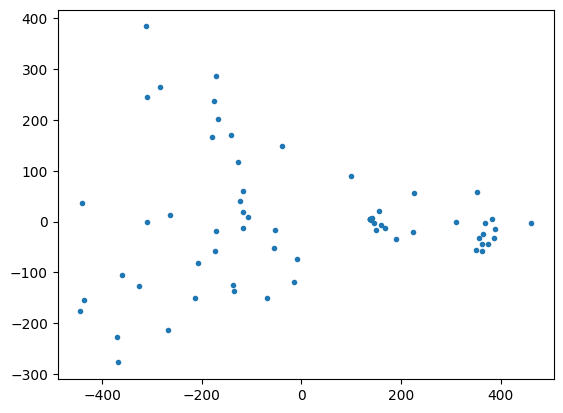

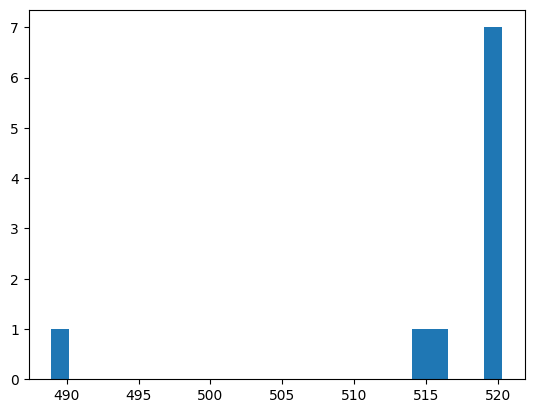

iter no. 150 mu=580.9290771484375, std=376.137451171875, loss=778235.9375
iter no. 151 mu=568.6151733398438, std=341.8683166503906, loss=715261.9375
iter no. 152 mu=555.6473999023438, std=391.5959777832031, loss=750821.625
iter no. 153 mu=530.1201171875, std=585.286865234375, loss=1013158.9375
iter no. 154 mu=392.16375732421875, std=891.3590087890625, loss=1540611.25
iter no. 155 mu=14.341951370239258, std=1210.04541015625, loss=2378942.5
iter no. 156 mu=-447.31256103515625, std=1480.347900390625, loss=3885120.0
iter no. 157 mu=-1057.042236328125, std=1659.53076171875, loss=6289615.5
iter no. 158 mu=-1652.4822998046875, std=2142.538330078125, loss=11894602.0
iter no. 159 mu=-1978.86181640625, std=3022.859130859375, loss=21207484.0
iter no. 160 mu=-1814.0390625, std=4512.05078125, loss=38419996.0
iter no. 161 mu=-1422.808837890625, std=7131.03271484375, loss=85898096.0
iter no. 162 mu=935.2432250976562, std=11335.900390625, loss=210173904.0
iter no. 163 mu=5511.61083984375, std=19291.04

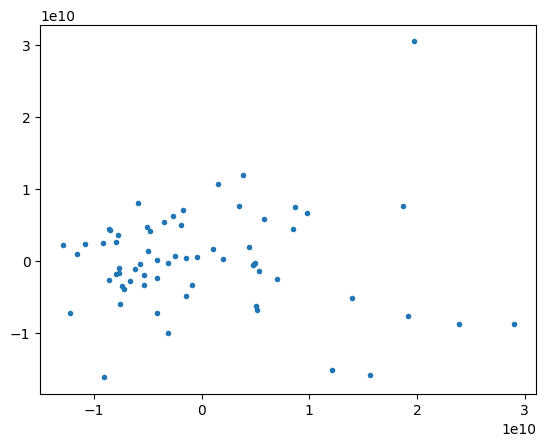

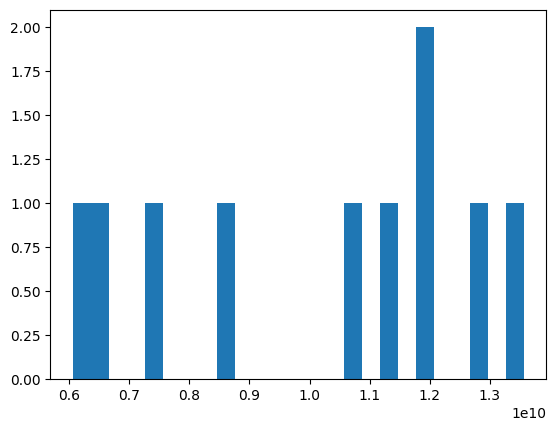

iter no. 200 mu=13616461824.0, std=18968657920.0, loss=8.857992888023882e+20
iter no. 201 mu=22606915584.0, std=29629374464.0, loss=2.256641464759648e+21
iter no. 202 mu=34436153344.0, std=41358721024.0, loss=4.705782540191807e+21
iter no. 203 mu=55152304128.0, std=62736953344.0, loss=1.1336797626089158e+22
iter no. 204 mu=89181347840.0, std=91973337088.0, loss=2.666593048725102e+22
iter no. 205 mu=130091810816.0, std=143723413504.0, loss=6.105765553086693e+22
iter no. 206 mu=204374360064.0, std=268450152448.0, loss=1.8494480428319828e+23
iter no. 207 mu=342551363584.0, std=542257774592.0, loss=6.683534961369838e+23
iter no. 208 mu=624687775744.0, std=983680876544.0, loss=2.2060433855863518e+24
iter no. 209 mu=986284294144.0, std=1851923759104.0, loss=7.152150283210832e+24
iter no. 210 mu=1941485387776.0, std=3943261798400.0, loss=3.1385075923609574e+25
iter no. 211 mu=3594339221504.0, std=8881520508928.0, loss=1.4913667773725275e+26
iter no. 212 mu=4563491356672.0, std=18678233956352.

AssertionError: underflow in dt nan

In [4]:
flow = HyperRegression(flow_args)
opt = _get_opt_(list(flow.hyper.parameters()) + list(flow.point_cnf.parameters()))
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from regressionFlow.utils import truncated_normal, standard_normal_logprob, standard_laplace_logprob
import numpy as np

def plotHist(X, n = 10):
  x = X.cpu().detach().numpy()[:n]
  plt.hist(x, bins = 25)
  plt.show()


def experiment_3(num_iter=1000,num_samples=10,do_norm_warmup=False):
    """
    FLOW zwraca kilka zestawow wag do klasyfikatora. Liczymy statystyki na skonkatenowanych zestawach wag, ktore raportujemy
    z kazda iteracja. Funkcja kosztu moze byc z warmupem normowym.
    num_iter: ilosc iteracji
    num_samples: ilosc zestawow wag generowanych z flowa do kazdej iteracji
    """
    support = torch.randn(5,65)
    batch_size = support.size(0)
    
    def get_sample_weights():
        """zwraca kilka zestawow wag z flowa"""
        weights = torch.empty(0).to('cuda')
        for _ in range(num_samples):
            y = flow.sample_gaussian((*support.shape, flow.input_dim), None, flow.gpu)
            x = flow.hyper(support)
            target_networks_weights = flow.point_cnf(y, x, reverse=True).view(*y.size())
            weights = torch.cat((weights, target_networks_weights.flatten()))
        return weights

    def get_sample_weights_loss():
        """zwraca kilka zestawow wag z flowa i ich lossy"""
        weights = torch.empty(0).to('cuda')
        _loss = None
        for _ in range(num_samples):
            y = flow.sample_gaussian((*support.shape, flow.input_dim), None, flow.gpu)
            x = flow.hyper(support)
            target_networks_weights = flow.point_cnf(y, x, reverse=True).view(*y.size())
            weights = torch.cat((weights, target_networks_weights.flatten()))

            # loss
            _, delta_log_py = flow.point_cnf(target_networks_weights, x, torch.zeros(batch_size, y.size(1), 1).to(y))
            log_py = standard_normal_logprob(y).view(batch_size, -1).sum(1, keepdim=True)
            delta_log_py = delta_log_py.view(batch_size, y.size(1), 1).sum(1)
            log_px = log_py - delta_log_py
            # policzyc gestosci flowa log p_0(F^{-1}_\theta(w_i) + J
            loss = log_px.mean()
            # policzyc gestosci priora log N(w_i | (0,I))
            size_multivariate = target_networks_weights.flatten().size()[0]
            multivariate_normal_distrib = torch.distributions.MultivariateNormal(
                    torch.zeros_like(target_networks_weights.flatten()).to(loss), torch.eye(size_multivariate).to(loss))
            loss_density = multivariate_normal_distrib.log_prob(target_networks_weights.flatten())
            loss = 0.01 * (loss - loss_density)
            if _loss is None:
                _loss = loss
            else:
                _loss = _loss + loss
        # print(f'weights {weights.shape}')
        return weights, _loss / num_samples

    def get_weights_stats(weights_samples) -> (float,float):
        """zwraca srednia i std z probki wag flowa do klasyfikatora"""
        mean = torch.mean(weights_samples)
        std = torch.std(weights_samples)
        return mean,std

    def get_mean_weight(weights_samples) -> torch.tensor:
        weights_samples = weights_samples.reshape(num_samples,-1)
        return torch.mean(weights_samples,0)

    def forward_experiment(norm_warmup=10):
        for i in range(num_iter):
            opt.zero_grad()

            loss = None
            if i <= norm_warmup and do_norm_warmup:
                weights = get_sample_weights()
            else:
                weights, loss = get_sample_weights_loss()
                
            mean, std = get_weights_stats(weights)
            target_network_weights = get_mean_weight(weights)


            if i <= norm_warmup and do_norm_warmup:
                loss = torch.norm(torch.flatten(target_network_weights))

            if i % 50 == 0:
                plotTheta(target_network_weights,loss)
                plotHist(target_network_weights)
            print(f"iter no. {i} mu={mean}, std={std}, loss={loss}")
            loss.backward()
            opt.step()
    forward_experiment()

experiment_3()
